In [1]:
from ALLCools.dmr.fimo import scan_motif_over_bed
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import anndata
import subprocess
from scipy.sparse import csr_matrix

In [5]:
bed_path = '/home/hanliu/project/mouse_rostral_brain/DMR/DGmCHGroup/DMR/TotalDMR.nofilter.bed'
motif_file_path = '/home/hanliu/ref/MEME/selected_motifs_sets/test_motif.meme'
genome_fasta_path = '/home/hanliu/ref/mouse/genome/fasta/raw/mm10.fa'
chrom_size_path = '/home/hanliu/ref/mouse/genome/mm10.main.chrom.sizes'

In [3]:
dmr_bed = pd.read_csv(bed_path, sep='\t', index_col=3, header=None, names=['chrom', 'start', 'end', 'name'])
dmr_bed.head()

,chrom,start,end
name,,,
DGmCH_0,chr1,3026310,3026310
DGmCH_1,chr1,3069892,3069892
DGmCH_2,chr1,3084771,3084771
DGmCH_3,chr1,3092179,3092179
DGmCH_4,chr1,3118806,3118806


In [4]:
output_path = pathlib.Path(bed_path).parent / 'MotifScan.h5ad'

## Scan motif

In [7]:
scan_motif_over_bed(
    bed_path=bed_path,
    motif_file=motif_file_path,
    genome_fasta=genome_fasta_path,
    output_dir =str(output_path) + "temp",
    chrom_size_path=chrom_size_path,
    cpu=40, 
    use_region_name=True,
    sort_mem_gbs=10
)

2 motifs to count.
Motif MA0006.1 Ahr::Arnt do not have any match under current settings.
/home/hanliu/project/mouse_rostral_brain/DMR/DGmCHGroup/DMR/MotifScan.h5adtemp/MA0139.1.meme, N motif total=52620


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ALLCools/dmr/fimo.py:60: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  final_df.to_msgpack(output_path, compress='zlib')
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ALLCools/dmr/fimo.py:108: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  lookup_table.to_msgpack(output_dir / f'LOOKUP_TABLE.msg')


In [9]:
ctcf = pd.read_msgpack('/home/hanliu/project/mouse_rostral_brain/DMR/DGmCHGroup/DMR/MotifScan.h5adtemp/MA0139.1.bed.msg')

In [12]:
ctcf['-lgp'] = -np.log10(ctcf['p-value'])

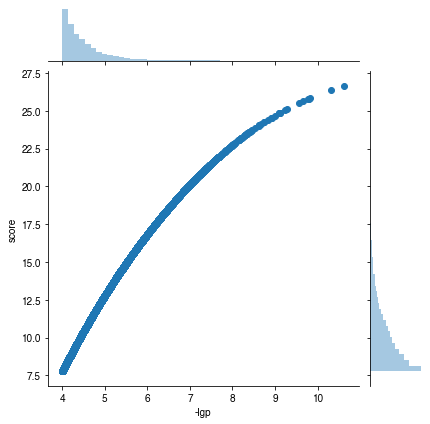

In [13]:
import seaborn as sns

sns.jointplot(data=ctcf, x='-lgp', y='score')

## Aggregate motif hits

In [7]:
temp_dir = pathlib.Path(str(output_path) + "temp")
results_path = list(temp_dir.glob('*bed.msg'))

In [19]:
rows = []
cols = []
datas = []
motif_ids = []
n = 0
for i, path in enumerate(results_path):
    n += 1
    if n % 100 == 0:
        print(n)
    df = pd.read_msgpack(path)
    motif_id = path.name[:-8]
    motif_ids.append(motif_id)
    
    dmr_max_scores = df.groupby('sequence_name')['score'].max()
    dmr_max_scores.index = dmr_max_scores.index.map(lambda i: i.split('_')[1]).astype(int)
    dmr_max_scores.sort_index(inplace=True)
    row = dmr_max_scores.index.values
    col = (np.ones_like(row) * i).astype(int)
    data = dmr_max_scores.values        
    rows.append(row)
    cols.append(col)
    datas.append(data)
rows = np.concatenate(rows)
cols = np.concatenate(cols)
datas = np.concatenate(datas)

hits = csr_matrix((datas, (rows, cols)),
                  shape=(dmr_bed.shape[0], len(motif_ids)))

dmr_hits = anndata.AnnData(X=hits,
                           obs=dmr_bed,
                           var=pd.DataFrame([], index=motif_ids))

dmr_hits.write_h5ad(output_path)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


100
200
300
400
500
600
700


... storing 'chrom' as categorical


In [21]:
dmr_hits

AnnData object with n_obs × n_vars = 243312 × 719 
    obs: 'chrom', 'start', 'end'

In [27]:
motif_hits_portion = ((dmr_hits.X > 0).sum(axis=0) / dmr_hits.X.shape[0]).A1

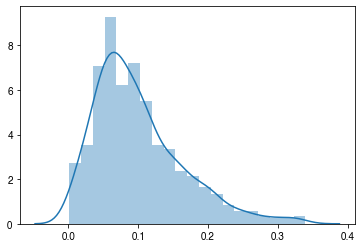

In [28]:
sns.distplot(motif_hits_portion)

## Delete temp dir

In [8]:
subprocess.run(['rm', '-rf', str(temp_dir)])

CompletedProcess(args=['rm', '-rf', '/home/hanliu/project/mouse_rostral_brain/DMR/DGmCHGroup/DMR/MotifScan.h5adtemp'], returncode=0)